# A/B Testing Course

## Lesson 5. Bootstrap & Confidence Intervals

### Homework

#### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm

#### Import Data

In [3]:
df_exp_users = pd.read_csv('experiment_users.csv')

In [4]:
df_web_logs = pd.read_csv('2022-04-13T12_df_web_logs.csv')

#### Data Description

df_exp_users - users split in the experiment:
- user_id - user identifier;
- pilot - test group flag.

df_web_logs - web logs information:
- user_id - user identifier;
- page - visited page;
- date - date and time of a page visit;
- load_time - page load time.

#### Checking Data

In [5]:
df_exp_users.head()

,user_id,pilot
0,c36b2e,0
1,20336e,0
2,034652,0
3,e98e3b,0
4,3f1105,0


In [6]:
df_exp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5456 non-null   object
 1   pilot    5456 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.4+ KB


In [7]:
df_web_logs.head()

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


In [8]:
df_web_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401709 entries, 0 to 2401708
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   page       object 
 2   date       object 
 3   load_time  float64
dtypes: float64(1), object(3)
memory usage: 73.3+ MB


In [9]:
df_web_logs.load_time.isna().sum()

0

#### Task 1. 

Experiment was held from 2022-04-05 to 2022-04-12.  
Check the significance of differences of other quantiles: 0.7; 0.74; 0.78; 0.82; 0.86; 0.90; 0.95; 0.99; 0.999; 0.9999  
When checking, use a normal confidence interval.

In [10]:
# filtering data by date
logs_filt = df_web_logs[(df_web_logs['date'] >= '2022-04-05') & \
                      (df_web_logs['date'] < '2022-04-12')]

In [11]:
# merging web logs and experiment groups data
df_groups = pd.merge(logs_filt, df_exp_users, how='inner', on='user_id')

In [12]:
# control and test groups data
load_time_a = df_groups[df_groups['pilot'] == 0]['load_time'].values
load_time_b = df_groups[df_groups['pilot'] == 1]['load_time'].values

In [13]:
# function to get normal confidence interval with help of bootstrap
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    c = norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right

In [14]:
# function to run bootstrap
def bootstrap(group_a, group_b, quantile, iterations=1000):
    # helper function to get point estimate
    def get_point_estimate(a_group, b_group, quantile=0.95):
        return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)
    
    # getting point estimate
    point_estimate = get_point_estimate(group_a, group_b, quantile=quantile)

    # bootstrapping data
    bs_point_estimates = []
    for _ in range(iterations):
        bs_a = np.random.choice(group_a, size=len(group_a), replace=True)
        bs_b = np.random.choice(group_b, size=len(group_b), replace=True)
        bs_point_estimate = get_point_estimate(bs_a, bs_b, quantile=quantile)
        bs_point_estimates.append(bs_point_estimate)
        
    return bs_point_estimates, point_estimate

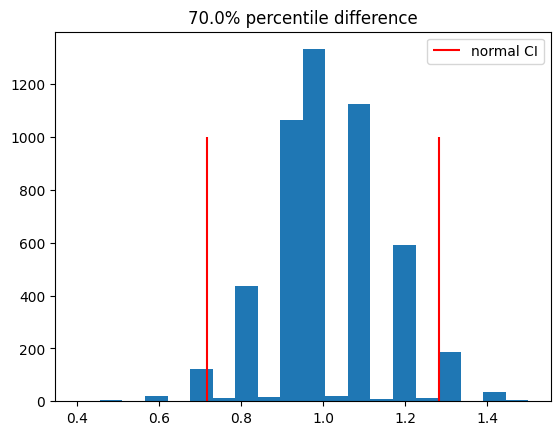

There is a significant difference!



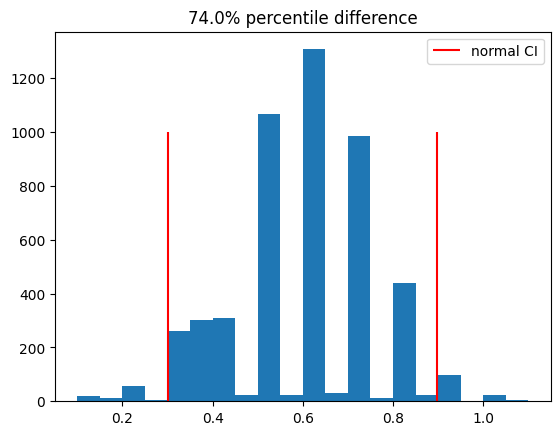

There is a significant difference!



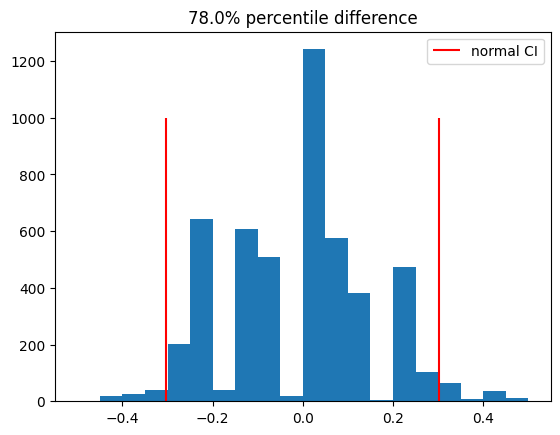

There is no significant effect here.



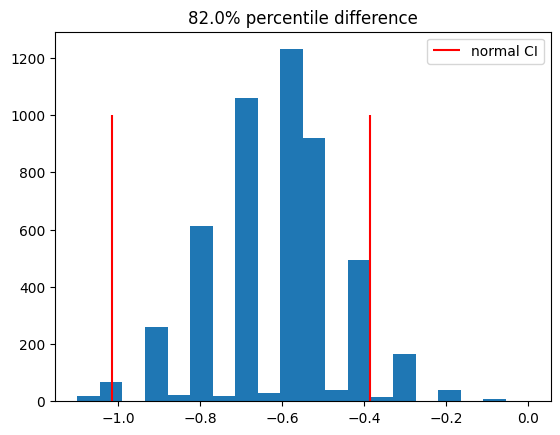

There is a significant difference!



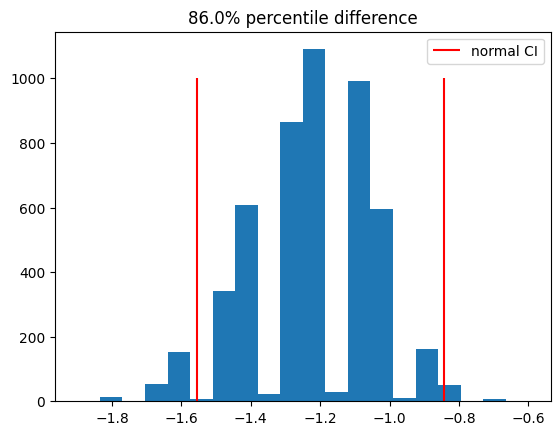

There is a significant difference!



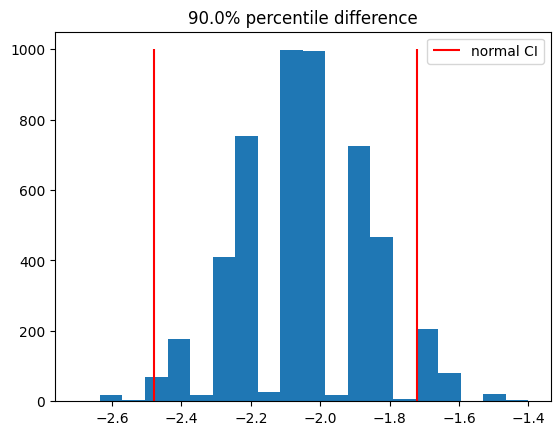

There is a significant difference!



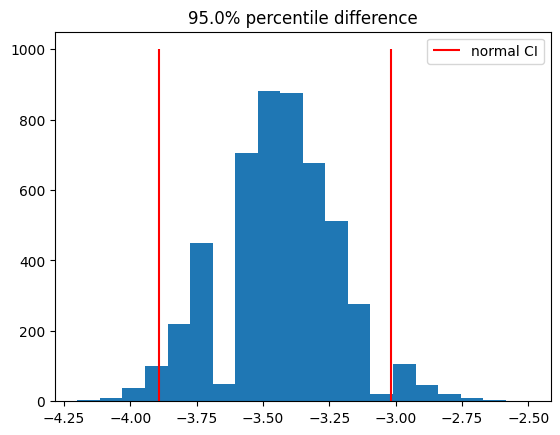

There is a significant difference!



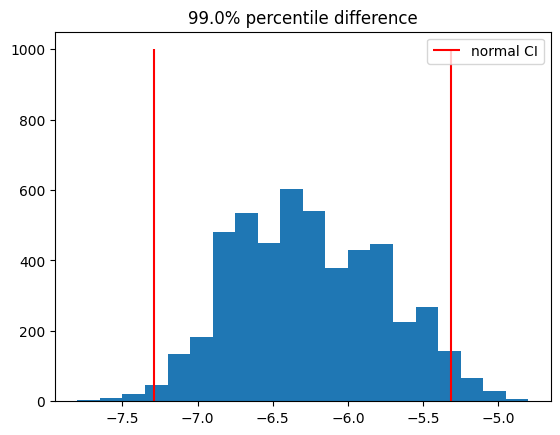

There is a significant difference!



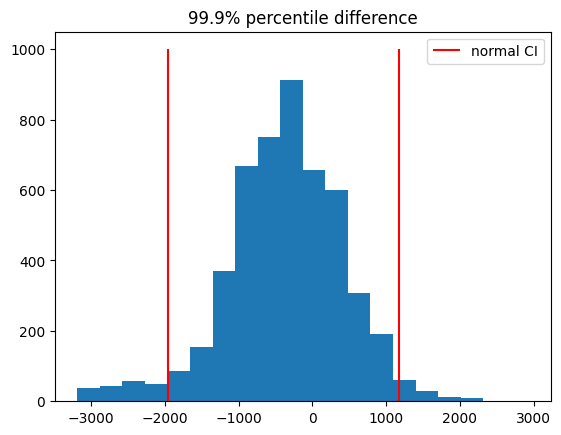

There is no significant effect here.



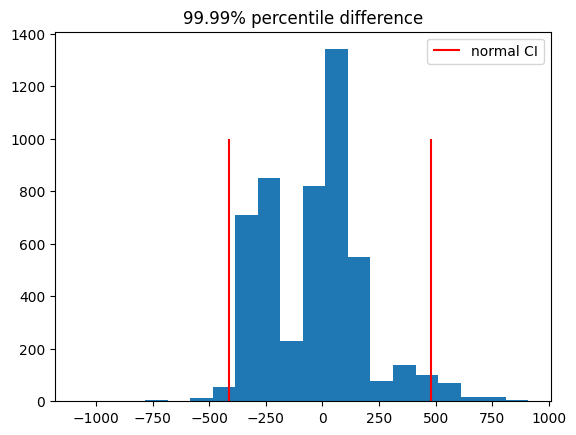

There is no significant effect here.



In [15]:
# lets check significance of difference for given percentiles
percentiles = [0.7, 0.74, 0.78, 0.82, 0.86, 0.90, 0.95, 0.99, 0.999, 0.9999]


for perc in percentiles:
    bs_data, pe = bootstrap(load_time_a, load_time_b, quantile=perc, iterations=5000)
    normal_ci = get_ci_bootstrap_normal(bs_data, pe)
    
    plt.title(f'{perc*100}% percentile difference')
    plt.hist(bs_data, bins=20);
    plt.vlines(normal_ci, 0, 1000, label='normal CI', color='red')
    plt.legend()
    plt.show()
    
    if normal_ci[0] > 0 or normal_ci[1] < 0:
        print('There is a significant difference!\n')
    else:
        print('There is no significant effect here.\n')

#### Task 2. 

#tbc..